#**Подготовка окружения**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Исследовательский анализ данных (EDA)**

Загрузка данных

In [43]:
import pandas as pd

# Загрузка данных
train_data = pd.read_parquet('train.parquet')
test_data = pd.read_parquet('test.parquet')

# Просмотр первых строк обучающей выборки
print(train_data.head())

# Просмотр первых строк тестовой выборки
print(test_data.head())

      id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0  
3  [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...    0.0  
4  [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...    0.0  
      id                                              dates  \
0   6125  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  26781  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
2  13333  [2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0... 

Проверим, есть ли пропуски в данных

In [79]:
print(train_data.isnull().sum())
print()
print(test_data.isnull().sum())

id            0
dates         0
values        0
label         0
values_len    0
dtype: int64

id        0
dates     0
values    0
dtype: int64


Посмотрим на распределение классов в обучающей выборке

In [80]:
print(train_data['label'].value_counts())

label
0.0    57820
1.0    22180
Name: count, dtype: int64


Статистики по временным рядам

In [46]:
# Длина временных рядов
train_data['values_len'] = train_data['values'].apply(len)
print(train_data['values_len'].describe())

count    80000.000000
mean        64.442650
std         15.399473
min         36.000000
25%         52.000000
50%         62.000000
75%         76.000000
max         97.000000
Name: values_len, dtype: float64


Проверка дисбаланса классов

In [52]:
print(train_labels.value_counts())

label
0.0    57820
1.0    22180
Name: count, dtype: int64


Визуализация данных

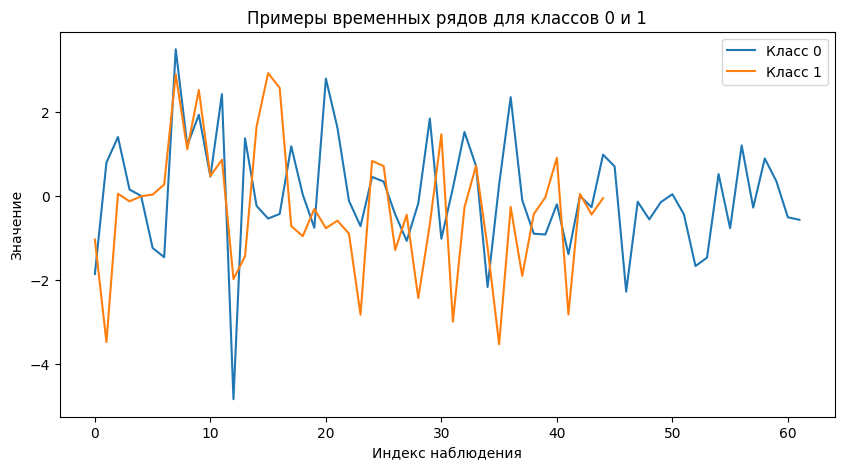

In [94]:
import matplotlib.pyplot as plt

# Визуализация примеров временных рядов
sample_series_0 = train_data[train_data['label'] == 0]['values'].iloc[0]
sample_series_1 = train_data[train_data['label'] == 1]['values'].iloc[0]

plt.figure(figsize=(10,5))
plt.plot(sample_series_0, label="Класс 0")
plt.plot(sample_series_1, label="Класс 1")
plt.legend()
plt.title("Примеры временных рядов для классов 0 и 1")
plt.xlabel("Индекс наблюдения")
plt.ylabel("Значение")
plt.show()

# **Генерация признаков**

Создание функции для генерации признаков

In [48]:
import numpy as np

# Функция для генерации признаков
def generate_features(data):
    features = pd.DataFrame()
    features['mean'] = data['values'].apply(np.mean)
    features['std'] = data['values'].apply(np.std)
    features['min'] = data['values'].apply(np.min)
    features['max'] = data['values'].apply(np.max)
    features['median'] = data['values'].apply(np.median)
    features['length'] = data['values'].apply(len)
    return features

# Генерация признаков для обучающей и тестовой выборки
train_features = generate_features(train_data)
test_features = generate_features(test_data)

print(train_features.head())

       mean       std       min   max    median  length
0  0.023710  1.337272 -4.840000  3.49 -0.110000      62
1 -0.310777  1.556337 -3.534409  2.92 -0.274409      45
2 -0.046042  1.065023 -1.950000  2.61 -0.145000      48
3 -0.130000  1.158201 -2.220000  2.49 -0.345000      48
4 -0.270536  1.270529 -2.500000  2.87 -0.475000      56


Добавление метки для обучения

In [50]:
train_labels = train_data['label']

# **Обучение модели**

Заполнение пропусков (импьютация)

In [61]:
from sklearn.impute import SimpleImputer

# Создаем импьютер, который заполнит пропуски средними значениями по столбцам
imputer = SimpleImputer(strategy='mean')

# Применяем импьютер ко всем признакам
X_train = imputer.fit_transform(X_train)

Обучение модели

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Разделим данные на обучающую и валидационную выборки
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Инициализируем модель
model = GradientBoostingClassifier()

# Обучаем модель
model.fit(X_train, y_train)

# Проверим качество на валидационной выборке
y_val_pred = model.predict_proba(X_val_split)[:, 1]
roc_auc = roc_auc_score(y_val_split, y_val_pred)
print(f'ROC AUC на валидации: {roc_auc}')

ROC AUC на валидации: 0.8398791731964571


Сохнанение модели

In [63]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# **Предсказание на тестовой выборке**

Преобразование тестовых данных

In [68]:
X_test = imputer.transform(test_features)

Загрузка обученной модели и создание файла с предсказаниями

In [83]:
# Загрузка тестовых данных
test = pd.read_parquet('test.parquet')

# Загрузка модели
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

predictions = model.predict_proba(X_test)[:, 1]

# Создание файла submission.csv
submission = pd.DataFrame({'id': test['id'], 'score': predictions})
submission.to_csv('submission.csv', index=False)

print("Файл submission.csv успешно создан!")

Файл submission.csv успешно создан!


Визуализация результатов

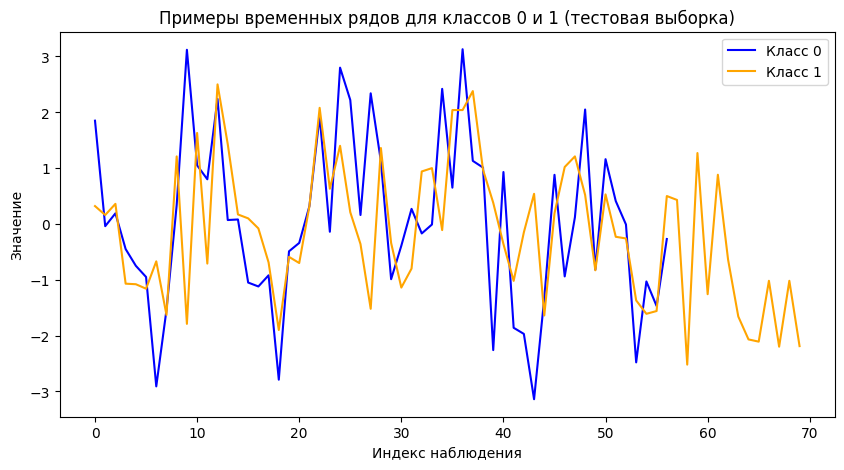

In [95]:
import matplotlib.pyplot as plt

# Извлечение временных рядов для классов 0 и 1
sample_series_0 = test[test['predicted_class'] == 0]['values'].iloc[0]
sample_series_1 = test[test['predicted_class'] == 1]['values'].iloc[0]

# Визуализация примеров временных рядов
plt.figure(figsize=(10, 5))
plt.plot(sample_series_0, label="Класс 0", color='blue')
plt.plot(sample_series_1, label="Класс 1", color='orange')
plt.legend()
plt.title("Примеры временных рядов для классов 0 и 1 (тестовая выборка)")
plt.xlabel("Индекс наблюдения")
plt.ylabel("Значение")
plt.show()